In [61]:
import dask.dataframe as dd
import dask.array as da
import os
import csv
import numba
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import dask
import xarray as xr
import scipy.io as sio
from skimage import exposure
from scipy.interpolate import interp1d
import dask_full_scene_analysis_helpers as hlp

In [3]:
solar_path = 'Aug14SolarRef.dat'
HySICS_wl_path = 'HySICS files/WLHysics.sav'

HySICS_LW_data_path = 'Desert_vegetation_clouds/'
LW_datacube_path = 'data_cube_water.npy'
LW_rgb_path = 'rgb_water.npy'
LRT_LW_path = 'WC files/'
verbose_LW_path = 'WC files/verbose/'

HySICS_IC_data_path = 'Thick_clouds1/'
IC_datacube_path = 'data_cube_ice.npy'
IC_rgb_path = 'rgb_ice.npy'
LRT_IC_path = 'IC files/'
verbose_IC_path = 'IC files/verbose/'

water_dict = {'solar_path':solar_path,'HySICS_wl_path':HySICS_wl_path,'HySICS_data_path':HySICS_LW_data_path, \
              'LRT_path':LRT_LW_path,'LRT_verbose_path':verbose_LW_path, 'phase':'Liquid Water', \
             'data_cube_path':LW_datacube_path,'rgb_path':LW_rgb_path}
ice_dict = {'solar_path':solar_path,'HySICS_wl_path':HySICS_wl_path,'HySICS_data_path':HySICS_IC_data_path, \
              'LRT_path':LRT_IC_path,'LRT_verbose_path':verbose_IC_path, 'phase':'Ice',\
           'data_cube_path':IC_datacube_path,'rgb_path':IC_rgb_path}

phase_dict=water_dict
path = LRT_LW_path
phase='Liquid Water'
wl_num=15

In [7]:
datacube = xr.open_dataarray('datacube_dvc.nc',chunks=10)
rgb = xr.open_dataarray('rgb_dvc.nc',chunks=10)

solar = hlp.read_solar(solar_path) 

lrt_files, lrt_radf_samp = hlp.get_sample_lrt_radf(path,phase)

solar_interp = hlp.interpolate_solar(lrt_radf_samp,solar)

retrieval_wl_list = hlp.find_retrieval_wavelengths(wl_num)
retrieval_idx_list = hlp.find_retrieval_idx_list(retrieval_wl_list,solar_interp)

refl_lrt_list = hlp.gen_refl_lrt_list(lrt_files,phase,solar_interp,phase)

In [58]:
xx = len(datacube[:,0,0])
yy = len(datacube[0,:,0])

x_array = np.arange(0,xx)
y_array = np.arange(0,yy)

tau_scene = np.zeros((xx,yy), dtype = float)
reff_scene = np.zeros((xx,yy), dtype = float)
mean_scene = np.zeros((xx,yy), dtype = float)
mask = np.zeros((xx,yy), dtype = float)

In [62]:
for y in tqdm_notebook(y_array):
    for x in x_array:
        rgb_pixel = rgb[x,y,:]
        mean_scene[x,y] = np.mean(rgb_pixel)
        
mask = mean_scene<0.75
masked_mean_scene = np.ma.array(mean_scene, mask=mask)

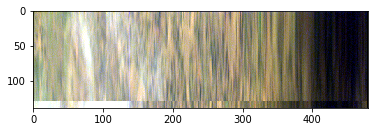

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(rgb)

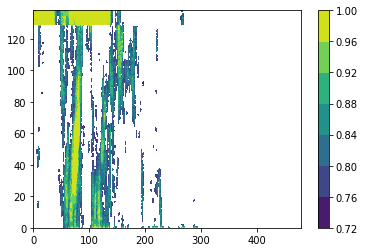

In [66]:
plt.contourf(y_array,x_array,masked_mean_scene)
plt.colorbar()

In [ ]:
def pop_scene(datacube,solar_interp,tau_scene,reff_scene,mask,x,y):
    if mask[x,y] == True: #Mask Ground On
        tau_scene[x,y] = 'NaN'
        reff_scene[x,y] = 'NaN'
            
    elif mask[x,y] == False: #Mask Ground Off    
        refl_hysics_pixel = hlp.calc_HySICS_reflectance(datacube_dvc,solar_interp,x,y)
        best_diff = hlp.calc_best_diff(refl_hysics_pixel,refl_lrt_list, retrieval_idx_list)
          
        tau_scene[x,y] = best_diff.COT
        reff_scene[x,y] = best_diff.r_eff
    return tau_scene, reff_scene;

for x in tqdm_notebook(x_array):
    for y in y_array:
        tau_scene, reff_scene  = pop_scene(datacube,solar_interp,tau_scene,reff_scene,mask,x,y)